# Setup

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats
import pingouin as pg
from pingouin import pairwise_gameshowell

# File import

In [262]:
cleavage = pd.read_excel('../Cleavage positions.xlsx', sheet_name = 'Cas12a_crRNA3', skiprows = 1).replace('None', np.nan)
no_log = cleavage.loc[:, :'sequence'].join(cleavage.loc[:, 'L_12s':])
cleavage_rate = cleavage.loc[:, :'sequence'].join(cleavage.loc[:, 'cleavage_rate_log':'cleavage_rate_log_unc'])
gRNA = pd.read_csv('gRNA_distances.csv')
Target = pd.read_csv('target_distances.csv')

# Features of the main sequence

In [263]:
pam_cas12 = 'TTTA'
pam_cas9 = 'TGG'
sequence = 'GTGATAAGTGGAATGCCATG'

In [264]:
OG_seq = cleavage[cleavage['sequence'] == pam_cas12 + sequence + pam_cas9]
OG_seq

,sequence,descriptor,cleavage_rate_log,cleavage_rate_log_unc,L_12s,L_3m,L_10m,L_100m,L_300m,L_1000m,L_3000m,R_12s,R_3m,R_10m,R_100m,R_300m,R_1000m,R_3000m
1842,TTTAGTGATAAGTGGAATGCCATGTGG,Matched,-1.819393,0.034901,NaN,23.79,23.69,23.25,22.93,22.82,NaN,NaN,19.1,19.15,19.04,19.1,19.21,NaN


# Creating Filters

In [265]:
def create_mismatches(sequence, pam_5_end='', pam_3_end=''):
    # When given a sequence, will generate all possible single and double mismatches
    # Can also add two PAMs on different ends
    mis_list = []
    
    # Single mismatches
    for i in range(len(sequence)):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base + sequence[i+1:] + pam_3_end
            #adds the base into a defined sequence, skipping the place where it gets added, that way simulating a mismatch
            mis_list.append(new_seq)

            # Double mismatches
            for j in range(i+1, len(sequence)):
                for base2 in 'ACGT':
                    new_seq2 = pam_5_end + sequence[:i] + base + sequence[i+1:j] + base2 + sequence[j+1:] + pam_3_end
                    mis_list.append(new_seq2)
                    
                    # Triple mismatches
                    #for f in range(i+2, len(sequence)):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base + sequence[i+1:j] + base2 + sequence[j+1:f] + base3 + sequence[f:] + pam_3_end
                            #mis_list.append(new_seq3)
    return mis_list
   
mismatch = create_mismatches(sequence, 'TTTA', 'TGG')

In [266]:
def create_del(sequence, pam_5_end = '', pam_3_end = ''):
    # When given a sequence, will generate all possible single, double, and triple deletions
    del_list = []
    
    # Single deletions
    for i in range(len(sequence)):
        new_seq = sequence[:i] + sequence[i+1:]
        del_list.append(new_seq)

        # Double deletions
        for j in range(i+1, len(sequence)):
            new_seq = sequence[:i] + sequence[i+1:j] + sequence[j+1:]
            #skipps one base, that way making a deletion
            del_list.append(new_seq)

            # Triple deletions
            #for k in range(j+1, len(sequence)):
                #new_seq = sequence[:i] + sequence[i+1:j] + sequence[j+1:k] + sequence[k+1:]
                #del_list.append(new_seq)

    return del_list

dels = create_del(sequence, 'TTTA', 'TGG')

In [267]:
def create_ins(sequence, pam_5_end = '', pam_3_end = ''):
    # When given a sequence, will generate all possible single, double, and triple insertions
    # Can also add two PAMs on different ends
    ins_list = []
    
    #Single insertion
    for i in range(len(sequence)+1):
        for base1 in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base1 + sequence[i:] + pam_3_end
            #adds a base 
            ins_list.append(new_seq)
            
            #Double insertion
            for j in range(i+1, len(sequence)+2):
                for base2 in 'ACGT':
                    new_seq2 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:] + pam_3_end
                    ins_list.append(new_seq2)
                    
                    #Triple insertion
                    #for k in range(j+1, len(sequence)+3):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:k] + base3 + sequence[k:] + pam_3_end
                            #ins_list.append(new_seq3)
    return ins_list

ins = create_ins(sequence, 'TTTA', 'TGG')

In [268]:
def create_small_ins(sequence, pam_5_end = '', pam_3_end = ''):
    #Will create insertions in a given sequence only at position 3 and 4 from the 3' end
    ins_list = []
    
    #Single insertion
    for i in range(-3, -1):
        for base1 in 'ACGT':
            new_seq = pam_5_end + sequence[:i] + base1 + sequence[i:] + pam_3_end
            ins_list.append(new_seq)
            
            #Double insertion
          #  for j in range(i+1, i+2):
           #     for base2 in 'ACGT':
            #        new_seq2 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:] + pam_3_end
             #       ins_list.append(new_seq2)
                    
                    #Triple insertion
                    #for k in range(j+1, len(sequence)+3):
                        #for base3 in 'ACGT':
                            #new_seq3 = pam_5_end + sequence[:i] + base1 + sequence[i:j] + base2 + sequence[j:k] + base3 + sequence[k:] + pam_3_end
                            #ins_list.append(new_seq3)
    return ins_list

small_ins = create_small_ins(sequence, 'TTTA', 'TGG')

In [269]:
def double_base(sequence, pam_5_end = '', pam_3_end = '', compare = ''):
    double_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+1]+sequence[x:] + pam_3_end
        double_seq.append(new_seq)
        
    if compare == 'yes':
        double_seq.append(double_seq[-1])
    return double_seq

double_base = double_base(sequence, 'TTTA', 'TGG', compare = 'yes')

In [270]:
def triple_base(sequence, pam_5_end = '', pam_3_end = '', compare = ''):
    triple_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+1] + sequence[x:x+1] + sequence[x:] + pam_3_end
        triple_seq.append(new_seq)
        
    if compare == 'yes':
        triple_seq.append(triple_seq[-1])
    
    return triple_seq

triple_bases = triple_base(sequence, 'TTTA', 'TGG', compare = 'yes')

In [271]:
def rep2_tribase(sequence, pam_5_end = '', pam_3_end = ''):
    triple_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x+2]+sequence[x:] + pam_3_end
        triple_seq.append(new_seq)
        
    return triple_seq

rep_base = rep2_tribase(sequence, 'TTTA', 'TGG')

In [272]:
def A_base(sequence, pam_5_end = '', pam_3_end = ''):
    A_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x]+ 'A' +sequence[x:] + pam_3_end
        A_seq.append(new_seq)
        
    return A_seq

A_ins = A_base(sequence, 'TTTA', 'TGG')

In [273]:
def C_base(sequence, pam_5_end = '', pam_3_end = ''):
    C_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x]+ 'C' +sequence[x:] + pam_3_end
        C_seq.append(new_seq)
        
    return C_seq

C_ins = C_base(sequence, 'TTTA', 'TGG')

In [274]:
def G_base(sequence, pam_5_end = '', pam_3_end = ''):
    G_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x]+ 'G' +sequence[x:] + pam_3_end
        G_seq.append(new_seq)
        
    return G_seq

G_ins = G_base(sequence, 'TTTA', 'TGG')

In [275]:
def T_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)):
        new_seq = pam_5_end + sequence[:x]+ 'T' +sequence[x:] + pam_3_end
        T_seq.append(new_seq)
        
    return T_seq

T_ins = T_base(sequence, 'TTTA', 'TGG')

In [276]:
def A2_base(sequence, pam_5_end = '', pam_3_end = ''):
    A_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'AA' +sequence[x:] + pam_3_end
        A_seq.append(new_seq)
        
    return A_seq

A2_ins = A2_base(sequence, 'TTTA', 'TGG')

In [277]:
def C2_base(sequence, pam_5_end = '', pam_3_end = ''):
    C_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'CC' +sequence[x:] + pam_3_end
        C_seq.append(new_seq)
        
    return C_seq

C2_ins = C2_base(sequence, 'TTTA', 'TGG')

In [278]:
def G2_base(sequence, pam_5_end = '', pam_3_end = ''):
    G_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'GG' +sequence[x:] + pam_3_end
        G_seq.append(new_seq)
        
    return G_seq

G2_ins = G2_base(sequence, 'TTTA', 'TGG')

In [279]:
def T2_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        new_seq = pam_5_end + sequence[:x]+ 'TT' +sequence[x:] + pam_3_end
        T_seq.append(new_seq)
        
    return T_seq

T2_ins = T2_base(sequence, 'TTTA', 'TGG')

In [280]:
def AN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'A{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

#Was too lazy to change the list names inside these functions, but since they have no impact on functionality, they might be changed some time later
AN_ins = AN_base(sequence, 'TTTA', 'TGG')

In [281]:
def CN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'C{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

CN_ins = CN_base(sequence, 'TTTA', 'TGG')

In [282]:
def GN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'G{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

GN_ins = GN_base(sequence, 'TTTA', 'TGG')

In [283]:
def TN_base(sequence, pam_5_end = '', pam_3_end = ''):
    T_seq = []
    for x in range(0, len(sequence)+1):
        for base in 'ACGT':
            new_seq = pam_5_end + sequence[:x]+ f'T{base}' +sequence[x:] + pam_3_end
            T_seq.append(new_seq)
        
    return T_seq

TN_ins = TN_base(sequence, 'TTTA', 'TGG')

# Filtering Data

In [284]:
#DataFrame with all possible insertions
ins_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)

#Dataframe with all possible insertions in 2X3 and 3X4
small_ins_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)
#dataframe with mismatches
mis_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)
#dataframe with deletions
del_df = pd.DataFrame(
    columns=['sequence',
             'L_12s', 'L_3m', 'L_10m', 'L_100m', 'L_300m', 'L_1000m', 'L_3000m',
             'R_12s', 'R_3m', 'R_10m', 'R_100m', 'R_300m', 'R_1000m', 'R_3000m']
)
#dataframe with insertions of a single base, that shares the identity of an adjecent base
doubles_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, that share the identity of an adjecent base
triples_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of a two bases, that share the identity of two adjecent bases
rep2_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just A
A_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just C
C_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just G
G_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of just T
T_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two As
Ad_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two Cs
Cd_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two Gs
Gd_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two Ts
Td_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being A, the other- any base
AN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being C, the other- any base
CN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being G, the other- any base
GN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#dataframe with insertions of two bases, the first being T, the other- any base
TN_df = pd.DataFrame(
    columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
)
#quatro_df = pd.DataFrame(
 #   columns = ['sequence', 'cleavage_rate_log', 'cleavage_rate_log_unc']
#)

In [285]:
#Fill the empty dataframes with data from created filters
#If running this cell with triple mismatches and more features, be ready to wait for at least 5 minutes

#for seq in ins:
#    matching_rows = no_log[no_log['sequence'] == seq]
#    ins_df = pd.concat([ins_df, matching_rows])

for seq in small_ins:
    matching_rows = no_log[no_log['sequence'] == seq]
    small_ins_df = pd.concat([small_ins_df, matching_rows])
    
#for seq in dels:
 #   matching_rows = no_log[no_log['sequence'] == seq]
  #  del_df = pd.concat([del_df, matching_rows])
    
#for seq in mismatch:
 #   matching_rows = no_log[no_log['sequence'] == seq]
  #  mis_df = pd.concat([mis_df, matching_rows])
    
for seq in double_base:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    doubles_df = pd.concat([doubles_df, matching_rows])
    
for seq in triple_bases:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    triples_df = pd.concat([triples_df, matching_rows])
    
for seq in rep_base:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    rep2_df = pd.concat([rep2_df, matching_rows])
    
for seq in A_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    A_df = pd.concat([A_df, matching_rows])
    
for seq in C_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    C_df = pd.concat([C_df, matching_rows])
    
for seq in G_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    G_df = pd.concat([G_df, matching_rows])
    
for seq in T_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    T_df = pd.concat([T_df, matching_rows])

for seq in A2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Ad_df = pd.concat([Ad_df, matching_rows])
    
for seq in C2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Cd_df = pd.concat([Cd_df, matching_rows])
    
for seq in G2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Gd_df = pd.concat([Gd_df, matching_rows])
    
for seq in T2_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    Td_df = pd.concat([Td_df, matching_rows])

for seq in AN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    AN_df = pd.concat([AN_df, matching_rows])
    
for seq in CN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    CN_df = pd.concat([CN_df, matching_rows])
    
for seq in GN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    GN_df = pd.concat([Gd_df, matching_rows])
    
for seq in TN_ins:
    matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
    TN_df = pd.concat([TN_df, matching_rows])
#for seq in quatro_bases:
  #  matching_rows = cleavage_rate[cleavage_rate['sequence'] == seq]
   # quatro_df = pd.concat([quatro_df, matching_rows])

# Visualization of Cut sites at one time point (might be redundant)

In [286]:
def swarm_data(df, column):
    
    #Will put the values from the column into a seperate dataframe based on the position of the bases and what base it is
    
    new_df = pd.DataFrame()

    data_df = df.dropna(subset=[column])

    for x in range(-7, -5):
        for base in 'ACGT':
            mask = (data_df['sequence'].str[x] == base)
            #will check each base in each of the defined positions 
            new_column_name = f'{abs(x)-3}{base}{abs(x)-4}'
            #names the column
            new_df[new_column_name] = data_df.loc[mask, column].reset_index(drop=True)
            #drop the data into the labeled column
    new_df = new_df.fillna(0)

    return new_df

In [287]:
def nona_count(df, column):
    
    #Counts how many non NaN values are in each column 
    
    new_df = pd.DataFrame()

    data_df = df.dropna(subset=[column])

    for x in range(-7, -5):
        for base in 'ACGT':
            mask = (data_df['sequence'].str[x] == base)
            new_column_name = f'{abs(x)-3}{base}{abs(x)-4}'
            new_df[new_column_name] = data_df.loc[mask, column].reset_index(drop=True)
        
    nona_count = new_df.notna().sum()
    return nona_count

In [288]:
def mean_df(df, column):
    
    #Will create a dataframe of average values for each column. This later is used in graph drawing
    
    mean_df = pd.DataFrame()

    for x in range(-7, -5):  #For each position 3 and 4
        for base in 'ACGT':  #Take a base
            notna_df = df[df[column].notna()]   #Filter the data that this column contains no NaN values
            average_cut = notna_df[notna_df['sequence'].str[x] == base][column].mean()   #find the sequences that contain that specific base in that specific position in that column
            column_name = f'{abs(x)-3}{base}{abs(x)-4}'   #Name the column of the empty dataframe
            mean_df.loc[0, column_name] = average_cut
    
    return mean_df

In [289]:
def mean_swarm(swarm, column, save = '', name = 'swarm with mean'):    
    
    #Will draw a strip plot of DNA cut sites, where a distribution of an average cut location based on the base in a certain position
    #will be depicted
    
    fig = plt.figure(figsize=(10, 7))
    sns.stripplot(data=swarm_data(swarm, column), orient="v", palette="Set2", size = 16, dodge=False, alpha = 0.3)
    #plt.scatter(x = mean_df(swarm, column).columns, y = mean_df(swarm, column), marker = 'o', color = 'black', s = 10, zorder = 10)
    plt.ylim(20, 25) #Change for Cas12a
    plt.axhline(2, color='grey', alpha = 0.5)
    plt.axhline(2.5, color='grey', alpha = 0.5, linestyle=':')
    plt.axhline(3, color='grey', alpha = 0.5)
    plt.axhline(3.5, color='grey', alpha = 0.5, linestyle=':')
    plt.axhline(4, color='grey', alpha = 0.5)
    plt.xlabel('Position of insertion')
    plt.ylabel('Median cut site after 1000 minutes of reaction')
    plt.title('Cut site position in sequences with a single insertion adjecent to a cannonical cut site')

    y_offset = 0.1
    for pos, count in enumerate(nona_count(swarm, column)):
        plt.text(pos - 0.2, 19.3 + y_offset, f'n = {count}')
    
    if save == 'yes':
        plt.savefig(f"PNG {name}.png")
        plt.savefig(f'SVG {name}.svg', format='svg', bbox_inches='tight')

In [290]:
swarm_data(small_ins_df, 'L_1000m')

,4A3,4C3,4G3,4T3,3A2,3C2,3G2,3T2
0,22.54,22.4,22.23,22.31,22.54,22.47,22.66,22.4
1,22.54,0.0,0.00,0.00,22.40,0.00,0.00,0.0
2,22.47,0.0,0.00,0.00,22.23,0.00,0.00,0.0
3,22.66,0.0,0.00,0.00,22.31,0.00,0.00,0.0
4,22.40,0.0,0.00,0.00,22.54,0.00,0.00,0.0


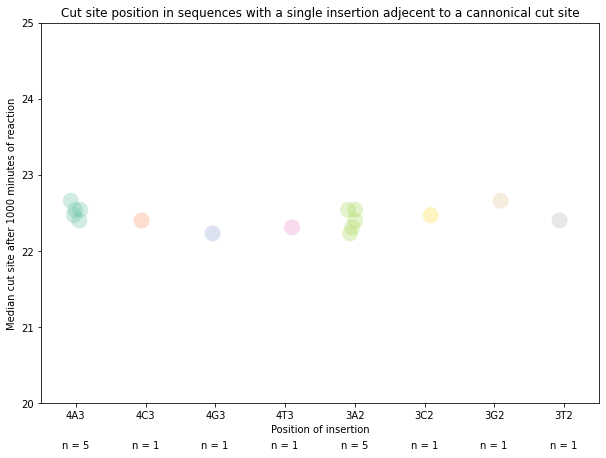

In [291]:
mean_swarm(small_ins_df, 'L_1000m')

In [292]:
small_ins_df

,sequence,L_12s,L_3m,L_10m,L_100m,L_300m,L_1000m,L_3000m,R_12s,R_3m,R_10m,R_100m,R_300m,R_1000m,R_3000m
2094,TTTAGTGATAAGTGGAATGCCAATGTGG,NaN,23.61,23.47,23.04,22.73,22.54,NaN,NaN,17.73,17.82,17.67,17.8,17.62,NaN
5534,TTTAGTGATAAGTGGAATGCCCATGTGG,NaN,22.93,22.66,22.55,22.49,22.4,NaN,NaN,17.6,17.5,17.44,17.62,17.65,NaN
2825,TTTAGTGATAAGTGGAATGCCGATGTGG,NaN,22.99,22.57,22.4,22.41,22.23,NaN,NaN,17.45,17.23,17.34,17.39,17.35,NaN
3008,TTTAGTGATAAGTGGAATGCCTATGTGG,NaN,22.81,22.52,22.5,22.44,22.31,NaN,NaN,17.33,17.38,17.39,17.24,17.25,NaN
2094,TTTAGTGATAAGTGGAATGCCAATGTGG,NaN,23.61,23.47,23.04,22.73,22.54,NaN,NaN,17.73,17.82,17.67,17.8,17.62,NaN
204,TTTAGTGATAAGTGGAATGCCACTGTGG,NaN,23.69,23.58,23.24,22.79,22.47,NaN,NaN,18.2,18.22,18.15,18.2,18.25,NaN
4232,TTTAGTGATAAGTGGAATGCCAGTGTGG,NaN,23.23,23.02,22.65,22.68,22.66,NaN,NaN,17.46,17.7,17.55,17.61,17.7,NaN
1522,TTTAGTGATAAGTGGAATGCCATTGTGG,NaN,23.78,23.62,22.85,22.55,22.4,NaN,NaN,18.07,18.25,18.02,18.15,18.06,NaN


# Visualization of change in Cut site location based on time 

In [293]:
def cut_kinetics(
    df, 
    column_start_name = 'sequence', 
    column_end_name = 'L_3000m', 
    ylim = [2.7, 4.2], 
    figsize = [10, 5]):

    # Will draw the kinetics of a nuclease 
    
    
    titles = []
    row_end = len(df)
    for x in range(-7, -5):
        for base in 'ACGT':
            new_title = f'Insertion at position {abs(x)-3}{base}'
            titles.append(new_title)

    cut_df = df.loc[:, column_start_name:column_end_name]
    trans_df = cut_df.transpose()
    
    #plt.figure(figsize = figsize)
    for x in range(0, len(cut_df)):
        column = trans_df.columns[x]  # get the column name instead of its contents
        data = trans_df[column].iloc[1:].dropna()  # drop NaN values in the column
        plt.figure(figsize = figsize)
        plt.plot(data)
        plt.scatter(x = trans_df.iloc[1:, x].index, y = trans_df.iloc[1:, x])
        plt.title(titles[x], size = 17)
        plt.ylabel('Average cut site', size = 15)
        plt.xlabel('Time point', size = 15)
        plt.ylim(ylim)
        plt.axhline(2, color='grey', alpha = 0.5)
        plt.axhline(2.5, color='grey', alpha = 0.5, linestyle=':')
        plt.axhline(3, color='grey', alpha = 0.5)
        plt.axhline(3.5, color='grey', alpha = 0.5, linestyle=':')
        plt.axhline(4, color='grey', alpha = 0.5)
        #plt.legend()

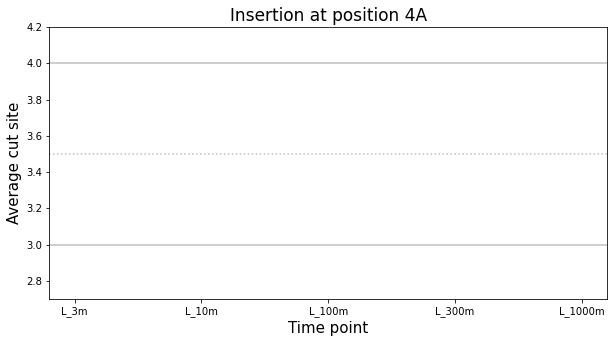

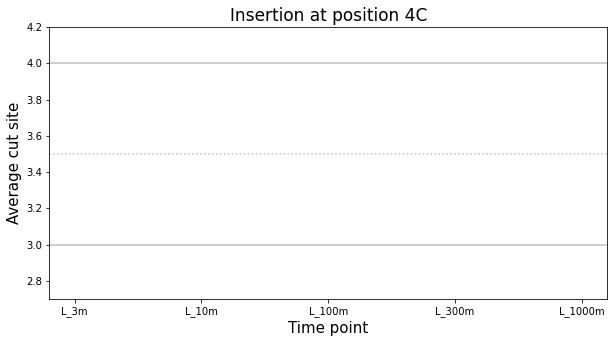

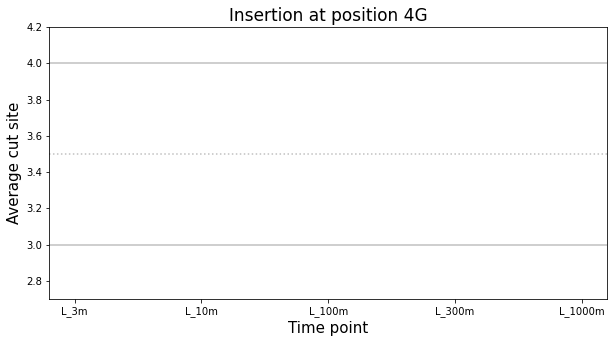

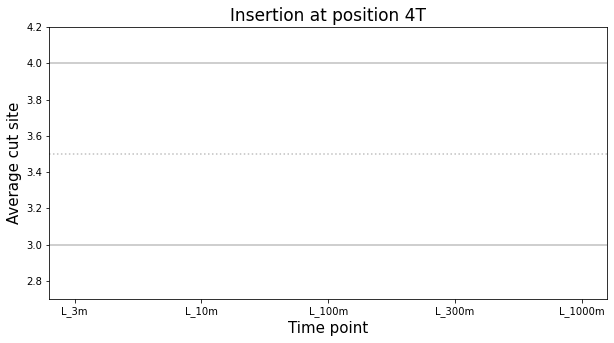

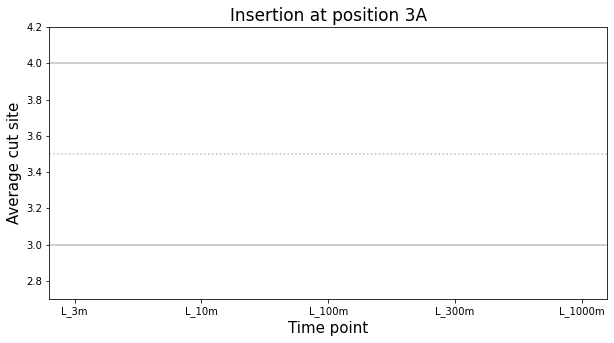

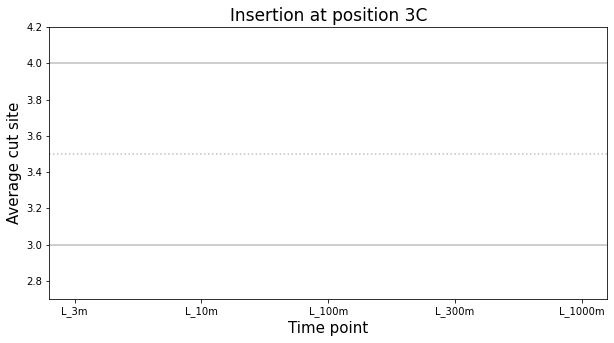

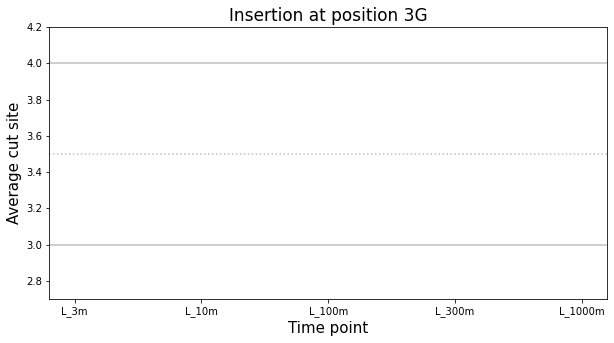

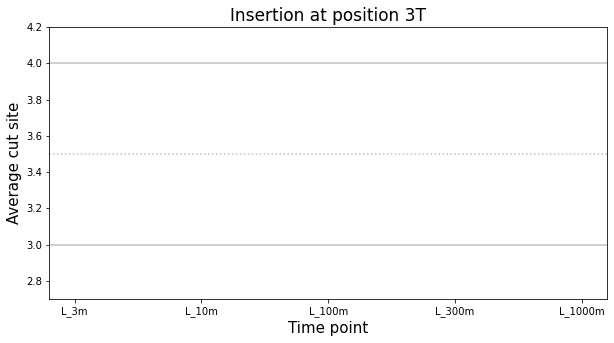

In [294]:
cut_kinetics(small_ins_df)

# Visualization of cut rate changes based on where a duplicated sequence is placed

In [295]:
cleavage[cleavage['sequence'].str.contains(f'^TTTA{sequence}TGG$')]

,sequence,descriptor,cleavage_rate_log,cleavage_rate_log_unc,L_12s,L_3m,L_10m,L_100m,L_300m,L_1000m,L_3000m,R_12s,R_3m,R_10m,R_100m,R_300m,R_1000m,R_3000m
1842,TTTAGTGATAAGTGGAATGCCATGTGG,Matched,-1.819393,0.034901,NaN,23.79,23.69,23.25,22.93,22.82,NaN,NaN,19.1,19.15,19.04,19.1,19.21,NaN


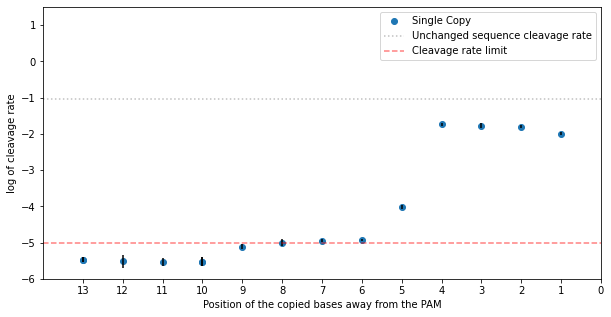

In [296]:
def cut_rate(df, x_axis='sequence', y_axis='cleavage_rate_log', y_error='cleavage_rate_log_unc', save = '', name = 'single cleavage rate'):
    
    #Creates the cleavage rate graph for a single data set 
    
    df = df.reset_index(drop=True)
    
    plt.figure(figsize=[10, 5])
    plt.scatter(x=df.loc[:, x_axis], y=df.loc[:, y_axis], label = 'Single Copy')#, color = 'blue')
    plt.errorbar(x=df.loc[:, x_axis], y=df.loc[:, y_axis], yerr=df.loc[:, y_error], fmt='none', color = 'black')
    
    plt.axhline(-1.032424, color='grey', alpha = 0.5, linestyle = ':', label = 'Unchanged sequence cleavage rate')
    plt.axhline(-5, color='red', alpha = 0.5, linestyle = '--', label = 'Cleavage rate limit')
    
    tick_labels = ['{}'.format(len(df)-2-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(df)), tick_labels)
    
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the copied bases away from the PAM')
    #plt.title('Cleavage rate dependency on duplicated base insertions')
    
    plt.xlim(-1, len(df)-2)
    plt.ylim(-6, 1.5)
    plt.legend()
    
    if save == 'yes':
        plt.savefig(f"PNG {name}.png")
        plt.savefig(f'SVG {name}.svg', format='svg', bbox_inches='tight')

cut_rate(rep2_df)

,df_sequence,df_cleavage_rate_log,df_cleavage_rate_log_unc,df1_sequence,df1_cleavage_rate_log,df1_cleavage_rate_log_unc
0,TTTAGGTGATAAGTGGAATGCCATGTGG,-3.415936,0.043921,TTTAGGGTGATAAGTGGAATGCCATGTGG,-5.595105,0.15879
1,TTTAGTTGATAAGTGGAATGCCATGTGG,-4.740718,0.06137,TTTAGTTTGATAAGTGGAATGCCATGTGG,-5.286128,0.067262
2,TTTAGTGGATAAGTGGAATGCCATGTGG,-3.409757,0.087148,TTTAGTGGGATAAGTGGAATGCCATGTGG,-5.6988,6.817615
3,TTTAGTGAATAAGTGGAATGCCATGTGG,-2.4291,0.031231,TTTAGTGAAATAAGTGGAATGCCATGTGG,-5.325774,0.165767
4,TTTAGTGATTAAGTGGAATGCCATGTGG,-2.525911,0.039165,TTTAGTGATTTAAGTGGAATGCCATGTGG,-5.214224,0.053024
5,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATAAAAGTGGAATGCCATGTGG,-5.521802,0.171277
6,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATAAAAGTGGAATGCCATGTGG,-5.521802,0.171277
7,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.138231,0.043153,TTTAGTGATAAGGGTGGAATGCCATGTGG,-5.713298,1.550156
8,TTTAGTGATAAGTTGGAATGCCATGTGG,-3.776608,0.061908,TTTAGTGATAAGTTTGGAATGCCATGTGG,-32.81227,31.851042
9,TTTAGTGATAAGTGGGAATGCCATGTGG,-3.552749,0.035472,TTTAGTGATAAGTGGGGAATGCCATGTGG,-5.109034,0.056864


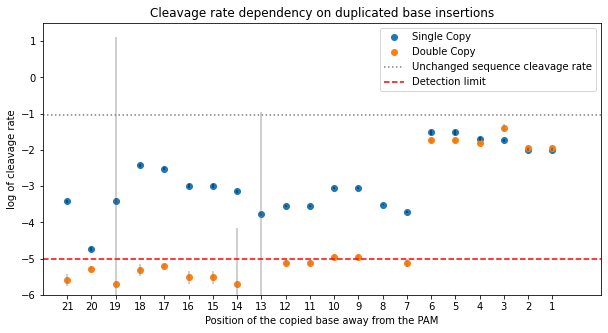

In [297]:
def cut_rate2(df, 
              df1, 
              legend1='Single Copy', 
              legend2='Double Copy', 
              legend3 = 'Unchanged sequence cleavage rate', 
              legend4 = 'Detection limit',
              save = '',
              name = 'sgRNA1'
):
    
    #Takes two dataframes and compares the cleavage rates between them also displaying the uncertainty
    
    df = df.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    j_df = df.add_prefix('df_')
    j_df1 = df1.add_prefix('df1_')
    joint_df = pd.concat([j_df, j_df1], axis=1)
    
    x_data = df.index
    
    plt.figure(figsize=[10, 5])
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], label=legend1)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], label=legend2)
    
    # Add uncertainty bars
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df_cleavage_rate_log_unc'], 
                 linestyle='None', color='black', alpha=0.5)
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df1_cleavage_rate_log_unc'], 
                 linestyle='None', color='grey', alpha=0.5)
    
    tick_labels = ['{}'.format(len(df)-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(joint_df)), tick_labels)
    plt.ylabel('log of cleavage rate')
    plt.xlabel('Position of the copied base away from the PAM')
    plt.title('Cleavage rate dependency on duplicated base insertions')
    
    plt.axhline(-1.032424, color='grey', alpha=1, linestyle=':', label = legend3)
    plt.axhline(-5, color='red', alpha=1, linestyle='--', label = legend4)
    
    plt.xlim(-1, len(joint_df)+1)
    plt.ylim(-6, 1.5)
    plt.legend(loc='best')    
    
    if save == 'yes':
        plt.savefig(f"PNG {name} 2 dataframes.png")
        plt.savefig(f'SVG {name} 2 dataframes.svg', format='svg', bbox_inches='tight')
    
    return joint_df

cut_rate2(doubles_df, triples_df)

# Visualization of single copy cleavage rates compared to a single insertion

In [298]:
Target[::-1].reset_index(drop=True)

,DNA 3' Carbon Atom,Closest Protein Atom,PAM relative position,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,DNA Atom 30,10.29,Bound to non target,NaN,NaN,NaN,NaN
1,DNA Atom 29,9.12,NaN,NaN,NaN,NaN,NaN
2,DNA Atom 28,7.97,NaN,NaN,NaN,NaN,NaN
3,DNA Atom 27,9.30,NaN,NaN,NaN,NaN,NaN
4,DNA Atom 26,9.07,NaN,NaN,NaN,NaN,NaN
5,DNA Atom 25,4.77,NaN,NaN,NaN,NaN,NaN
6,DNA Atom 24,3.70,NaN,NaN,NaN,NaN,NaN
7,DNA Atom 23,3.29,NaN,NaN,NaN,NaN,NaN
8,DNA Atom 22,4.06,NaN,NaN,NaN,NaN,NaN
9,DNA Atom 21,4.22,NaN,PAM ends,NaN,NaN,Not interested in


In [299]:
def cut_pos_table(dna,
                   rna,
                  df1, 
                  df2, 
                  df3, 
                  df4
):    
    dna = dna.iloc[:20, 1:3]
    dna = dna[::-1]
    rna = rna.iloc[19:39, 1:3]
    
    df1 = df1.reset_index(drop=True)
    df2 = df2.reset_index(drop=True)
    df3 = df3.reset_index(drop=True)
    df4 = df4.reset_index(drop=True)
    dna = dna.reset_index(drop=True)
    rna = rna.reset_index(drop=True)
    
    j_dna = dna.add_prefix('dna_')
    j_rna = rna.add_prefix('rna_')
    j_df1 = df1.add_prefix('df1_')
    j_df2 = df2.add_prefix('df2_')
    j_df3 = df3.add_prefix('df3_')
    j_df4 = df4.add_prefix('df4_')
    joint_df = pd.concat([j_dna, j_rna, j_df1, j_df2, j_df3, j_df4], axis=1)
    
    return joint_df

cut_pos_table(Target, gRNA, A_df, C_df, G_df, T_df)

,dna_Closest Protein Atom,dna_PAM relative position,rna_Distance to Closest Protein Atom,rna_PAM relative position,df1_sequence,df1_cleavage_rate_log,df1_cleavage_rate_log_unc,df2_sequence,df2_cleavage_rate_log,df2_cleavage_rate_log_unc,df3_sequence,df3_cleavage_rate_log,df3_cleavage_rate_log_unc,df4_sequence,df4_cleavage_rate_log,df4_cleavage_rate_log_unc
0,3.96,1,4.88,1,TTTAAGTGATAAGTGGAATGCCATGTGG,-4.841124,0.042923,TTTACGTGATAAGTGGAATGCCATGTGG,-4.063543,0.085446,TTTAGGTGATAAGTGGAATGCCATGTGG,-3.415936,0.043921,TTTATGTGATAAGTGGAATGCCATGTGG,-4.804939,0.029428
1,5.11,2,4.14,2,TTTAGATGATAAGTGGAATGCCATGTGG,-4.993038,0.120461,TTTAGCTGATAAGTGGAATGCCATGTGG,-5.361436,0.18513,TTTAGGTGATAAGTGGAATGCCATGTGG,-3.415936,0.043921,TTTAGTTGATAAGTGGAATGCCATGTGG,-4.740718,0.06137
2,4.11,3,4.55,3,TTTAGTAGATAAGTGGAATGCCATGTGG,-5.267141,0.070231,TTTAGTCGATAAGTGGAATGCCATGTGG,-5.821642,0.984253,TTTAGTGGATAAGTGGAATGCCATGTGG,-3.409757,0.087148,TTTAGTTGATAAGTGGAATGCCATGTGG,-4.740718,0.06137
3,4.30,4,4.60,4,TTTAGTGAATAAGTGGAATGCCATGTGG,-2.4291,0.031231,TTTAGTGCATAAGTGGAATGCCATGTGG,-5.094327,0.040113,TTTAGTGGATAAGTGGAATGCCATGTGG,-3.409757,0.087148,TTTAGTGTATAAGTGGAATGCCATGTGG,-4.473186,0.029822
4,3.76,5,4.26,5,TTTAGTGAATAAGTGGAATGCCATGTGG,-2.4291,0.031231,TTTAGTGACTAAGTGGAATGCCATGTGG,-3.398771,0.027841,TTTAGTGAGTAAGTGGAATGCCATGTGG,-2.901253,0.058866,TTTAGTGATTAAGTGGAATGCCATGTGG,-2.525911,0.039165
5,4.41,6,4.34,6,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATCAAGTGGAATGCCATGTGG,-3.430075,0.039822,TTTAGTGATGAAGTGGAATGCCATGTGG,-3.525304,0.030578,TTTAGTGATTAAGTGGAATGCCATGTGG,-2.525911,0.039165
6,3.31,7,3.84,7,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATACAGTGGAATGCCATGTGG,-4.817728,0.037621,TTTAGTGATAGAGTGGAATGCCATGTGG,-4.645252,0.022416,TTTAGTGATATAGTGGAATGCCATGTGG,-4.244789,0.023309
7,4.12,8,4.37,8,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATAACGTGGAATGCCATGTGG,-4.431446,0.039896,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.138231,0.043153,TTTAGTGATAATGTGGAATGCCATGTGG,-4.203903,0.026513
8,3.85,9,8.74,9,TTTAGTGATAAGATGGAATGCCATGTGG,-3.111736,0.042133,TTTAGTGATAAGCTGGAATGCCATGTGG,-3.845808,0.060656,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.138231,0.043153,TTTAGTGATAAGTTGGAATGCCATGTGG,-3.776608,0.061908
9,4.47,10,8.94,10,TTTAGTGATAAGTAGGAATGCCATGTGG,-4.065052,0.042684,TTTAGTGATAAGTCGGAATGCCATGTGG,-4.562095,0.023889,TTTAGTGATAAGTGGGAATGCCATGTGG,-3.552749,0.035472,TTTAGTGATAAGTTGGAATGCCATGTGG,-3.776608,0.061908


In [300]:
def cut_rate_table(df, 
                  df1, 
                  df2, 
                  df3, 
                  df4
):    
    df = df.reset_index(drop=True)
    df1 = df1.reset_index(drop=True)
    df2 = df2.reset_index(drop=True)
    df3 = df3.reset_index(drop=True)
    df4 = df4.reset_index(drop=True)
    j_df = df.add_prefix('df_')
    j_df1 = df1.add_prefix('df1_')
    j_df2 = df2.add_prefix('df2_')
    j_df3 = df3.add_prefix('df3_')
    j_df4 = df4.add_prefix('df4_')
    joint_df = pd.concat([j_df, j_df1, j_df2, j_df3, j_df4], axis=1)
    
    return joint_df

cut_rate_table(doubles_df, A_df, C_df, G_df, T_df)

,df_sequence,df_cleavage_rate_log,df_cleavage_rate_log_unc,df1_sequence,df1_cleavage_rate_log,df1_cleavage_rate_log_unc,df2_sequence,df2_cleavage_rate_log,df2_cleavage_rate_log_unc,df3_sequence,df3_cleavage_rate_log,df3_cleavage_rate_log_unc,df4_sequence,df4_cleavage_rate_log,df4_cleavage_rate_log_unc
0,TTTAGGTGATAAGTGGAATGCCATGTGG,-3.415936,0.043921,TTTAAGTGATAAGTGGAATGCCATGTGG,-4.841124,0.042923,TTTACGTGATAAGTGGAATGCCATGTGG,-4.063543,0.085446,TTTAGGTGATAAGTGGAATGCCATGTGG,-3.415936,0.043921,TTTATGTGATAAGTGGAATGCCATGTGG,-4.804939,0.029428
1,TTTAGTTGATAAGTGGAATGCCATGTGG,-4.740718,0.06137,TTTAGATGATAAGTGGAATGCCATGTGG,-4.993038,0.120461,TTTAGCTGATAAGTGGAATGCCATGTGG,-5.361436,0.18513,TTTAGGTGATAAGTGGAATGCCATGTGG,-3.415936,0.043921,TTTAGTTGATAAGTGGAATGCCATGTGG,-4.740718,0.06137
2,TTTAGTGGATAAGTGGAATGCCATGTGG,-3.409757,0.087148,TTTAGTAGATAAGTGGAATGCCATGTGG,-5.267141,0.070231,TTTAGTCGATAAGTGGAATGCCATGTGG,-5.821642,0.984253,TTTAGTGGATAAGTGGAATGCCATGTGG,-3.409757,0.087148,TTTAGTTGATAAGTGGAATGCCATGTGG,-4.740718,0.06137
3,TTTAGTGAATAAGTGGAATGCCATGTGG,-2.4291,0.031231,TTTAGTGAATAAGTGGAATGCCATGTGG,-2.4291,0.031231,TTTAGTGCATAAGTGGAATGCCATGTGG,-5.094327,0.040113,TTTAGTGGATAAGTGGAATGCCATGTGG,-3.409757,0.087148,TTTAGTGTATAAGTGGAATGCCATGTGG,-4.473186,0.029822
4,TTTAGTGATTAAGTGGAATGCCATGTGG,-2.525911,0.039165,TTTAGTGAATAAGTGGAATGCCATGTGG,-2.4291,0.031231,TTTAGTGACTAAGTGGAATGCCATGTGG,-3.398771,0.027841,TTTAGTGAGTAAGTGGAATGCCATGTGG,-2.901253,0.058866,TTTAGTGATTAAGTGGAATGCCATGTGG,-2.525911,0.039165
5,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATCAAGTGGAATGCCATGTGG,-3.430075,0.039822,TTTAGTGATGAAGTGGAATGCCATGTGG,-3.525304,0.030578,TTTAGTGATTAAGTGGAATGCCATGTGG,-2.525911,0.039165
6,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATACAGTGGAATGCCATGTGG,-4.817728,0.037621,TTTAGTGATAGAGTGGAATGCCATGTGG,-4.645252,0.022416,TTTAGTGATATAGTGGAATGCCATGTGG,-4.244789,0.023309
7,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.138231,0.043153,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATAACGTGGAATGCCATGTGG,-4.431446,0.039896,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.138231,0.043153,TTTAGTGATAATGTGGAATGCCATGTGG,-4.203903,0.026513
8,TTTAGTGATAAGTTGGAATGCCATGTGG,-3.776608,0.061908,TTTAGTGATAAGATGGAATGCCATGTGG,-3.111736,0.042133,TTTAGTGATAAGCTGGAATGCCATGTGG,-3.845808,0.060656,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.138231,0.043153,TTTAGTGATAAGTTGGAATGCCATGTGG,-3.776608,0.061908
9,TTTAGTGATAAGTGGGAATGCCATGTGG,-3.552749,0.035472,TTTAGTGATAAGTAGGAATGCCATGTGG,-4.065052,0.042684,TTTAGTGATAAGTCGGAATGCCATGTGG,-4.562095,0.023889,TTTAGTGATAAGTGGGAATGCCATGTGG,-3.552749,0.035472,TTTAGTGATAAGTTGGAATGCCATGTGG,-3.776608,0.061908


In [301]:
OG_seq = cleavage[cleavage['sequence'] == pam_cas12 + sequence + pam_cas9].reset_index(drop=True)
OG_seq

,sequence,descriptor,cleavage_rate_log,cleavage_rate_log_unc,L_12s,L_3m,L_10m,L_100m,L_300m,L_1000m,L_3000m,R_12s,R_3m,R_10m,R_100m,R_300m,R_1000m,R_3000m
0,TTTAGTGATAAGTGGAATGCCATGTGG,Matched,-1.819393,0.034901,NaN,23.79,23.69,23.25,22.93,22.82,NaN,NaN,19.1,19.15,19.04,19.1,19.21,NaN


C:\Users\justa\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\justa\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\justa\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\justa\anaconda3\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
C:\Users\justa\anaconda3\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\justa\anaconda3\lib\site-packages\numpy\core\_

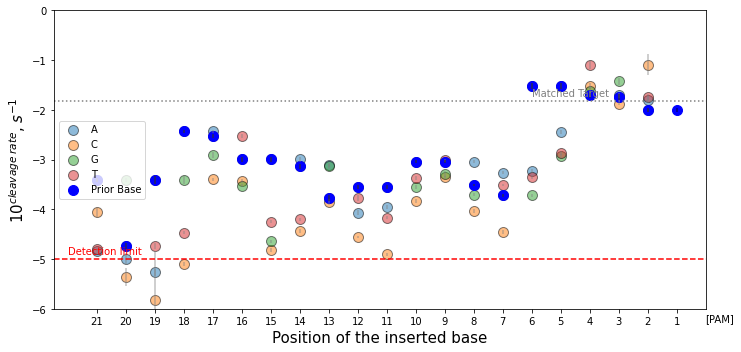

In [302]:
def cut_rate_comp(df, 
                  df1, 
                  df2, 
                  df3, 
                  df4, 
                  legend = '',
                  legend1 = 'Prior Base', 
                  legend2 = 'A', 
                  legend3 = 'C', 
                  legend4 = 'G', 
                  legend5 = 'T', 
                  save = '',
                  name = 'sgRNA1'
):
    
    #Takes multiple dataframes and compares the cleavage rates between them
    
    joint_df = cut_rate_table(df, df1, df2, df3, df4)
    
    x_data = joint_df.index
    
    plt.figure(figsize=[10, 5])
    #plt.scatter(x=x_data, y=joint_df.loc[:19, 'df_cleavage_rate_log'], color = 'blue', label=legend1)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], s = 100, edgecolor='black', alpha = 0.5, label=legend2)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df2_cleavage_rate_log'], s = 100, edgecolor='black', alpha = 0.5, label=legend3)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df3_cleavage_rate_log'], s = 100, edgecolor='black', alpha = 0.5, label=legend4)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df4_cleavage_rate_log'], s = 100, edgecolor='black', alpha = 0.5, label=legend5)
    plt.scatter(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], s = 100, color = 'blue', label=legend1)
    
    for x in range(1, 5):
        plt.errorbar(x = x_data, y = joint_df.loc[:, f'df{x}_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, f'df{x}_cleavage_rate_log_unc'], 
                 linestyle='None', color='grey', alpha=0.5)
    
    plt.errorbar(x=x_data, y=joint_df.loc[:, 'df_cleavage_rate_log'], 
                 yerr=joint_df.loc[:, 'df_cleavage_rate_log_unc'], 
                 linestyle='None', color='black', alpha=0.5)
    
    tick_labels = ['{}'.format(len(df)-x) for x in range(0, len(df))]
    plt.xticks(range(0, len(joint_df)), tick_labels)
    plt.ylabel('$10^{cleavage_ rate}$, $s^{-1}$', size=15)
    plt.xlabel('Position of the inserted base', size = 15)
    #plt.title('Cleavage rate comparison between sequences with different insertions and sequences with a single duplicated base')
    
    matched = cleavage[cleavage['sequence'] == pam_cas12 + sequence + pam_cas9].iloc[0, 2]   #cleavage is not defined in the function
    plt.axhline(matched, color='grey', alpha=1, linestyle=':')
    plt.axhline(-5, color='red', alpha=1, linestyle='--')
    
    plt.xlim(-1.5, len(joint_df))
    plt.ylim(-6, 0)
    
    if legend == 'outside':
        plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left')
        plt.tight_layout()  
    else:
        plt.legend(loc='center left')
        plt.tight_layout()   
    
    plt.text(21, -6.255, '[PAM]')
    plt.text(-1, -4.9, 'Detection limit', color = 'red')
    plt.text(15, matched + 0.1, 'Matched Target', color = 'grey')
    
    if save == 'yes':
        plt.savefig(f"PNG {name} 2 dataframes.png")
        plt.savefig(f'SVG {name} 2 dataframes.svg', format='svg', bbox_inches='tight')

cut_rate_comp(doubles_df, A_df, C_df, G_df, T_df)

# Distance and Rate

## Single insertions and deletions

In [303]:
# Make the insertion generation one nt shorter (not 21, but 20 in length)
# Make means of the cleavage rates
# Simulate one less insertion
# Perform the statistics
## What are the variables
## What is our question
## What test is appropriate

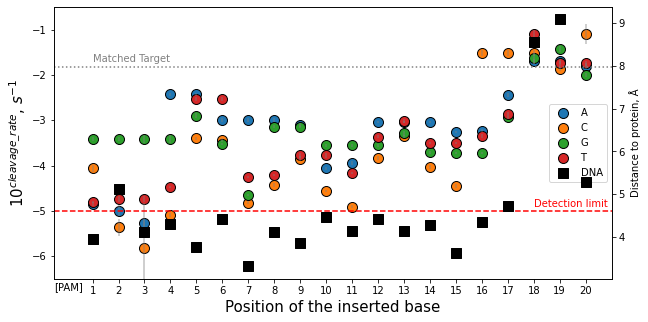

In [337]:
def cut_dis_comp(dna, 
                 rna,
                 df1,
                 df2,
                 df3,
                 df4,
                 strand='DNA',
                 legend='',
                 legend1='DNA',
                 legend1_1='RNA',
                 legend2='A',
                 legend3='C',
                 legend4='G',
                 legend5='T',
                 save='',
                 name='Cas12a'
                ):
    
    joint_df = cut_pos_table(dna, rna, df1, df2, df3, df4)
    
    x_data = joint_df.index
    
    fig, ax1 = plt.subplots(figsize=[10, 5])
    
    ax1.scatter(x=x_data, y=joint_df.loc[:, 'df1_cleavage_rate_log'], s=100, edgecolor='black', label=legend2)
    ax1.scatter(x=x_data, y=joint_df.loc[:, 'df2_cleavage_rate_log'], s=100, edgecolor='black', label=legend3)
    ax1.scatter(x=x_data, y=joint_df.loc[:, 'df3_cleavage_rate_log'], s=100, edgecolor='black', label=legend4)
    ax1.scatter(x=x_data, y=joint_df.loc[:, 'df4_cleavage_rate_log'], s=100, edgecolor='black', label=legend5)
    
    for x in range(1, 5):
        ax1.errorbar(x=x_data, y=joint_df.loc[:, f'df{x}_cleavage_rate_log'],
                     yerr=joint_df.loc[:, f'df{x}_cleavage_rate_log_unc'],
                     linestyle='None', color='grey', alpha=0.5)
    
    ax1.set_xticks(range(len(joint_df)))
    ax1.set_xticklabels(['{}'.format(x+1) for x in range(len(joint_df))])
    ax1.set_xlabel('Position of the inserted base', size=15)
    
    ax1.set_ylabel('$10^{cleavage\_rate}$, $s^{-1}$', size=15)
    
    ax2 = ax1.twinx()
    if strand == 'DNA':
        ax2.scatter(x_data, joint_df['dna_Closest Protein Atom'], s=100, edgecolor='black', marker='s', color='black', label=legend1)
    elif strand == 'RNA':
        ax2.scatter(x_data, joint_df['rna_Distance to Closest Protein Atom'], s=100, edgecolor='black', marker='s', color='black', label=legend1_1)
    else:
        ax2.scatter(x_data, joint_df['dna_Closest Protein Atom'], s=100, edgecolor='black', marker='s', color='black', label=legend1)
        ax2.scatter(x_data, joint_df['rna_Distance to Closest Protein Atom'], s=100, edgecolor='black', marker='s', color='black', label=legend1_1)
    
    ax2.set_ylabel('Distance to protein, \u00C5')
    ax2.lines.clear()  # Remove the line plot

    matched = cleavage[cleavage['sequence'] == pam_cas12 + sequence + pam_cas9].iloc[0, 2]
    ax1.axhline(matched, color='grey', alpha=1, linestyle=':')
    ax1.axhline(-5, color='red', alpha=1, linestyle='--')
    
    ax1.set_xlim(-1.5, len(joint_df))
    ax1.set_ylim(-6.5, -0.5)
    
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    
    if strand == 'DNA':
        labels1.append(legend1)
    elif strand == 'RNA':
        labels1.append(legend1_1)
    
    handles1.extend(handles2)
    labels1.extend(labels2)
    
    ax1.legend(handles1, labels1, loc='best')
    
    ax1.text(-1.5, -6.755, '[PAM]')
    ax1.text(17, -4.9, 'Detection limit', color='red')
    ax1.text(0, matched + 0.1, 'Matched Target', color='grey')
    
    if save == 'yes':
        plt.savefig(f"PNG {name} 2 dataframes.png")
        plt.savefig(f'SVG {name} 2 dataframes.svg', format='svg', bbox_inches='tight')

cut_dis_comp(Target, gRNA, A_df, C_df, G_df, T_df, strand = 'DNA')

In [305]:
# Should I also calculate the mean of the error bars for each data point and display it as the error bar of the means?
# Change the line for distances to scatter in the shape of diamonds or smthuing similar

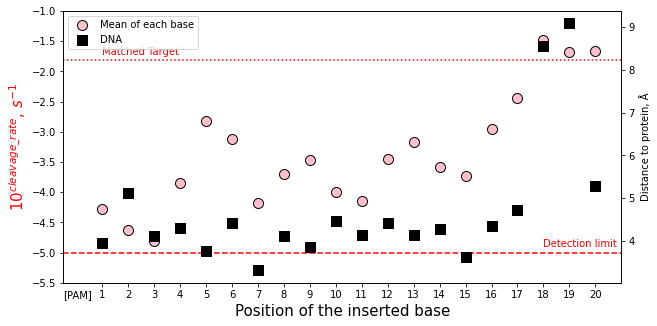

In [342]:
def mean_dist(   dna, 
                 rna,
                 df1,
                 df2,
                 df3,
                 df4,
                 strand='DNA',
                 legend='',
                 legend1='DNA',
                 legend1_1='RNA',
                 legend2='Mean of each base',
                 save='',
                 name='Cas12a mean'
                ):
    
    joint_df = cut_pos_table(dna, rna, df1, df2, df3, df4)
    
    log = '_cleavage_rate_log'
    columns_to_average = ['df1'+log, 'df2'+log, 'df3'+log, 'df4'+log]
    joint_df['Mean'] = joint_df[columns_to_average].mean(axis=1)
    x_data = joint_df.index
    
    fig, ax1 = plt.subplots(figsize=[10, 5])
    
    # Scatter plots for df2, df3, df4, and df
    ax1.scatter(x=x_data, y=joint_df.loc[:, 'Mean'], s=100, color='pink', edgecolor='black', label=legend2)
    
    # X-axis and labels
    ax1.set_xticks(range(len(joint_df)))
    ax1.set_xticklabels(['{}'.format(x+1) for x in range(len(joint_df))])
    ax1.set_xlabel('Position of the inserted base', size=15)
    
    # Y-axis on the left
    ax1.set_ylabel('$10^{cleavage\_rate}$, $s^{-1}$', size=15)
    
    ax1.yaxis.label.set_color('red')  # Change the color of the y-axis label to red
    ax1.tick_params(axis='y', colors='black')  # Change the color of the y-axis ticks to red
    
    ax2 = ax1.twinx()  # Create a second y-axis
    if strand == 'DNA':
        ax2.scatter(x_data, joint_df['dna_Closest Protein Atom'], s=100, edgecolor='black', marker='s', color='black', label=legend1)
    elif strand == 'RNA':
        ax2.scatter(x_data, joint_df['rna_Distance to Closest Protein Atom'], s=100, edgecolor='black', marker='s', color='black', label=legend1_1)
    else:
        ax2.scatter(x_data, joint_df['dna_Closest Protein Atom'], s=100, edgecolor='black', marker='s', color='black', label=legend1)
        ax2.scatter(x_data, joint_df['rna_Distance to Closest Protein Atom'], s=100, edgecolor='black', marker='s', color='black', label=legend1_1)
    
    ax2.set_ylabel('Distance to protein, \u00C5')
    ax2.lines.clear()  # Remove the line plot

    matched = cleavage[cleavage['sequence'] == pam_cas12 + sequence + pam_cas9].iloc[0, 2]  # Define 'cleavage'
    ax1.axhline(matched, color='red', alpha=1, linestyle=':')
    ax1.axhline(-5, color='red', alpha=1, linestyle='--')
    
    ax1.set_xlim(-1.5, len(joint_df))
    ax1.set_ylim(-5.5, -1)
    
    # Combine all legend labels and handles into a single legend
    handles, labels = ax1.get_legend_handles_labels()
    handles.append(ax2.collections[0])  # Add the scatter plot handle to the legend
    if strand == 'DNA':
        labels.append(legend1)  # Add the 'Distance' label to the legend
    elif strand == 'RNA':
        labels.append(legend1_1)
    else:
        labels.append(legend1)
        labels.append(legend1_1)
    
    ax1.legend(handles, labels, loc='upper left')
    
    ax1.text(-1.5, -5.755, '[PAM]')
    ax1.text(17, -4.9, 'Detection limit', color='red')
    ax1.text(0, matched + 0.1, 'Matched Target', color='red')
    
    if save == 'yes':
        plt.savefig(f"PNG {name} 2 dataframes.png")
        plt.savefig(f'SVG {name} 2 dataframes.svg', format='svg', bbox_inches='tight')

mean_dist(Target, gRNA, A_df, C_df, G_df, T_df, strand='DNA')

# Distance and Position

# Statistics

### Welch ANOVA

In [307]:
#collect all the data I need
table = cut_rate_table(doubles_df, A_df, C_df, G_df, T_df)

#remove the doubles_df
table_wide = table.loc[:, ['df1_cleavage_rate_log', 'df2_cleavage_rate_log', 'df3_cleavage_rate_log', 'df4_cleavage_rate_log']] 

#only doubles_df
dup_data = pd.DataFrame(table.loc[:, 'df_cleavage_rate_log']) 

#turn both wide dataframes into long formats
long = table_wide.melt(value_name='value').reset_index(drop = True)
long_dup = dup_data.melt(value_name='value').reset_index(drop = True)

#Mark what values need to be removed
values_to_exclude = long_dup['value'].unique()      #Can hide this

# Filter out the rows from the bigger dataframe that match the values in the smaller dataframe
filtered_df = long[~long['value'].isin(values_to_exclude)].reset_index(drop = True)     #Can hide this

#Concat the two dataframes
#concated_df = pd.concat([long, long_dup], ignore_index=True).dropna()
concated_df = pd.concat([filtered_df, long_dup], ignore_index=True).dropna()   #Can hide this

# Create separate data arrays for each category
categories = concated_df['variable'].unique()
data_arrays = [concated_df[concated_df['variable'] == cat]['value'].values for cat in categories]

# Perform Welch ANOVA
f_statistic, p_value = stats.f_oneway(*data_arrays)

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 3.308977747807449
p-value: 0.01612809275143011


In [308]:
#Doubles and Triples dfs comparison

double_df = doubles_df.reset_index(drop=True)
triple_df= triples_df.reset_index(drop=True)
j_df = double_df.add_prefix('df_')
j_df1 = triple_df.add_prefix('df1_')
table_wide = pd.concat([j_df, j_df1], axis = 1)
table_wide = table_wide.loc[:, ['df_cleavage_rate_log', 'df1_cleavage_rate_log']]
table_long = table_wide.melt(value_name='value').dropna()

# Create separate data arrays for each category
categories = table_long['variable'].unique()
data_arrays = [table_long[table_long['variable'] == cat]['value'].values for cat in categories]

# Perform Welch ANOVA
f_statistic, p_value = stats.f_oneway(*data_arrays)

# Print the results
print("F-statistic:", f_statistic)
print("p-value:", p_value)

F-statistic: 4.7175592473364505
p-value: 0.03584215719836476


### Mann-Whitney-Wilcoxon criteria

In [309]:
    joint_df = cut_pos_table(Target, gRNA, A_df, C_df, G_df, T_df)
    
    log = '_cleavage_rate_log'
    columns_to_average = ['df1'+log, 'df2'+log, 'df3'+log, 'df4'+log]
    joint_df['Mean'] = joint_df[columns_to_average].mean(axis=1)

statistic, p_value = stats.mannwhitneyu(joint_df.loc[:, 'Mean'], joint_df.loc[:, 'rna_Distance to Closest Protein Atom'])

# Print the test statistic and p-value
print("Mann-Whitney U Statistic:", statistic)
print("P-Value:", p_value)

Mann-Whitney U Statistic: 0.0
P-Value: 6.786038616738627e-08


### Spearman

In [312]:
# Creating the table for average values to be used in Spearman
joint_df = cut_pos_table(Target, gRNA, A_df, C_df, G_df, T_df)
    
log = '_cleavage_rate_log'
columns_to_average = ['df1'+log, 'df2'+log, 'df3'+log, 'df4'+log]
joint_df['Mean'] = joint_df[columns_to_average].mean(axis=1)

#Decide if want to compare between DNA or RNA distances
nucleo = input('DNA or RNA?')
if nucleo == 'DNA':
    x = joint_df.loc[:, 'dna_Closest Protein Atom']

elif nucleo == 'RNA':
    x = joint_df.loc[:, 'rna_Distance to Closest Protein Atom']
y = joint_df.loc[:, 'Mean']

corr_coefficient, p_value = stats.spearmanr(x, y)
print('correlation coefficient:', corr_coefficient)
print('p value:', p_value)

DNA or RNA? DNA


correlation coefficient: 0.4904099632256468
p value: 0.028142582135020536


In [313]:
joint_df

,dna_Closest Protein Atom,dna_PAM relative position,rna_Distance to Closest Protein Atom,rna_PAM relative position,df1_sequence,df1_cleavage_rate_log,df1_cleavage_rate_log_unc,df2_sequence,df2_cleavage_rate_log,df2_cleavage_rate_log_unc,df3_sequence,df3_cleavage_rate_log,df3_cleavage_rate_log_unc,df4_sequence,df4_cleavage_rate_log,df4_cleavage_rate_log_unc,Mean
0,3.96,1,4.88,1,TTTAAGTGATAAGTGGAATGCCATGTGG,-4.841124,0.042923,TTTACGTGATAAGTGGAATGCCATGTGG,-4.063543,0.085446,TTTAGGTGATAAGTGGAATGCCATGTGG,-3.415936,0.043921,TTTATGTGATAAGTGGAATGCCATGTGG,-4.804939,0.029428,-4.281385
1,5.11,2,4.14,2,TTTAGATGATAAGTGGAATGCCATGTGG,-4.993038,0.120461,TTTAGCTGATAAGTGGAATGCCATGTGG,-5.361436,0.18513,TTTAGGTGATAAGTGGAATGCCATGTGG,-3.415936,0.043921,TTTAGTTGATAAGTGGAATGCCATGTGG,-4.740718,0.06137,-4.627782
2,4.11,3,4.55,3,TTTAGTAGATAAGTGGAATGCCATGTGG,-5.267141,0.070231,TTTAGTCGATAAGTGGAATGCCATGTGG,-5.821642,0.984253,TTTAGTGGATAAGTGGAATGCCATGTGG,-3.409757,0.087148,TTTAGTTGATAAGTGGAATGCCATGTGG,-4.740718,0.06137,-4.809815
3,4.30,4,4.60,4,TTTAGTGAATAAGTGGAATGCCATGTGG,-2.4291,0.031231,TTTAGTGCATAAGTGGAATGCCATGTGG,-5.094327,0.040113,TTTAGTGGATAAGTGGAATGCCATGTGG,-3.409757,0.087148,TTTAGTGTATAAGTGGAATGCCATGTGG,-4.473186,0.029822,-3.851592
4,3.76,5,4.26,5,TTTAGTGAATAAGTGGAATGCCATGTGG,-2.4291,0.031231,TTTAGTGACTAAGTGGAATGCCATGTGG,-3.398771,0.027841,TTTAGTGAGTAAGTGGAATGCCATGTGG,-2.901253,0.058866,TTTAGTGATTAAGTGGAATGCCATGTGG,-2.525911,0.039165,-2.813759
5,4.41,6,4.34,6,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATCAAGTGGAATGCCATGTGG,-3.430075,0.039822,TTTAGTGATGAAGTGGAATGCCATGTGG,-3.525304,0.030578,TTTAGTGATTAAGTGGAATGCCATGTGG,-2.525911,0.039165,-3.118033
6,3.31,7,3.84,7,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATACAGTGGAATGCCATGTGG,-4.817728,0.037621,TTTAGTGATAGAGTGGAATGCCATGTGG,-4.645252,0.022416,TTTAGTGATATAGTGGAATGCCATGTGG,-4.244789,0.023309,-4.174653
7,4.12,8,4.37,8,TTTAGTGATAAAGTGGAATGCCATGTGG,-2.990843,0.05088,TTTAGTGATAACGTGGAATGCCATGTGG,-4.431446,0.039896,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.138231,0.043153,TTTAGTGATAATGTGGAATGCCATGTGG,-4.203903,0.026513,-3.691106
8,3.85,9,8.74,9,TTTAGTGATAAGATGGAATGCCATGTGG,-3.111736,0.042133,TTTAGTGATAAGCTGGAATGCCATGTGG,-3.845808,0.060656,TTTAGTGATAAGGTGGAATGCCATGTGG,-3.138231,0.043153,TTTAGTGATAAGTTGGAATGCCATGTGG,-3.776608,0.061908,-3.468096
9,4.47,10,8.94,10,TTTAGTGATAAGTAGGAATGCCATGTGG,-4.065052,0.042684,TTTAGTGATAAGTCGGAATGCCATGTGG,-4.562095,0.023889,TTTAGTGATAAGTGGGAATGCCATGTGG,-3.552749,0.035472,TTTAGTGATAAGTTGGAATGCCATGTGG,-3.776608,0.061908,-3.989126
